# 미국 수제 맥주 산업 분석과 신제품 포지셔닝

2023.11.19 ~ 2023.11.21

## 1. 프로젝트 개요
- **주제: 미국 수제 맥주 산업 분석과 신제품 포지셔닝**
- 설명: 미국의 수제 맥주 및 양조장 데이터를 분석하여 수제 맥주 산업을 이루는 요소들을 탐색하고, 가상의 신규 제품을 개발해 보는 과정을 수행
- 사용한 데이터셋
    - [Craft Beers Dataset](https://www.kaggle.com/datasets/nickhould/craft-cans/)(Kaggle): 미국의 캔맥주 2K+, 미국의 500개 이상 양조장 데이터
- 진행 절차 및 내용
    - 수제 맥주 데이터, 양조장 데이터를 로딩하여 **각 컬럼별 EDA 및 결측치 처리**
    - **선형회귀분석**을 통해 핵심 컬럼들 간의 관계를 분석하고 통계적으로 검증
    - **클러스터링**을 통해 가상의 신규 제품 'HONEY DEW'의 시장 내 포지셔닝 진행
- 사용한 스킬셋
    - Pandas, Numpy
    - Matplotlib, Seaborn
    - Scipy
    - Scikit-learn (KMeansClustering)

## 2. 데이터 로딩 및 분포 확인

### 2-1. beers.csv

#### 2-1-1. 데이터 불러오기

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans

In [2]:
beers_df = pd.read_csv('beers.csv', index_col=0)
beers_df

,abv,ibu,id,name,style,brewery_id,ounces
0,0.050,NaN,1436,Pub Beer,American Pale Lager,408,12.0
1,0.066,NaN,2265,Devil's Cup,American Pale Ale (APA),177,12.0
2,0.071,NaN,2264,Rise of the Phoenix,American IPA,177,12.0
3,0.090,NaN,2263,Sinister,American Double / Imperial IPA,177,12.0
4,0.075,NaN,2262,Sex and Candy,American IPA,177,12.0
...,...,...,...,...,...,...,...
2405,0.067,45.0,928,Belgorado,Belgian IPA,424,12.0
2406,0.052,NaN,807,Rail Yard Ale,American Amber / Red Ale,424,12.0
2407,0.055,NaN,620,B3K Black Lager,Schwarzbier,424,12.0
2408,0.055,40.0,145,Silverback Pale Ale,American Pale Ale (APA),424,12.0


In [6]:
beers_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2410 entries, 0 to 2409
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   abv         2348 non-null   float64
 1   ibu         1405 non-null   float64
 2   id          2410 non-null   int64  
 3   name        2410 non-null   object 
 4   style       2405 non-null   object 
 5   brewery_id  2410 non-null   int64  
 6   ounces      2410 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 150.6+ KB


In [7]:
beers_df.isna().sum()

abv             62
ibu           1005
id               0
name             0
style            5
brewery_id       0
ounces           0
dtype: int64

```beers_df```를 보면서 생각한 점
- 컬럼명 한글화
- abv, ibu 컬럼 null값 처리
- 컬럼별로 분포 확인

In [3]:
named_beers_df = beers_df.rename(columns={
    'abv': '알코올 도수',
    'ibu': '쓴 정도',
    # id는 안 바꾸기
    'name': '이름',
    'style': '스타일',
    # brewery_id는 안 바꾸기
    'ounces': '질량'
})

named_beers_df

,알코올 도수,쓴 정도,id,이름,스타일,brewery_id,질량
0,0.050,NaN,1436,Pub Beer,American Pale Lager,408,12.0
1,0.066,NaN,2265,Devil's Cup,American Pale Ale (APA),177,12.0
2,0.071,NaN,2264,Rise of the Phoenix,American IPA,177,12.0
3,0.090,NaN,2263,Sinister,American Double / Imperial IPA,177,12.0
4,0.075,NaN,2262,Sex and Candy,American IPA,177,12.0
...,...,...,...,...,...,...,...
2405,0.067,45.0,928,Belgorado,Belgian IPA,424,12.0
2406,0.052,NaN,807,Rail Yard Ale,American Amber / Red Ale,424,12.0
2407,0.055,NaN,620,B3K Black Lager,Schwarzbier,424,12.0
2408,0.055,40.0,145,Silverback Pale Ale,American Pale Ale (APA),424,12.0


#### 2-1-2. 컬럼별 분포 확인(이름)

In [67]:
named_beers_df['이름'].nunique()

2305

데이터 개수가 2410개인데 이름의 고유값이 2305종류라는 것은 중복으로 들어간 게 105개라는 뜻 같다.

In [72]:
named_beers_df[named_beers_df['이름'].duplicated()].sort_values('이름')

,알코올 도수,쓴 정도,id,이름,스타일,brewery_id,질량
1254,0.051,20.0,360,#9,Fruit / Vegetable Beer,303,12.0
304,0.056,37.0,886,1327 Pod's ESB,Extra Special / Strong Bitter (ESB),380,12.0
305,0.056,37.0,612,1327 Pod's ESB,Extra Special / Strong Bitter (ESB),380,12.0
916,0.054,30.0,2202,312 Urban Pale Ale,American Pale Ale (APA),88,12.0
918,0.042,18.0,1829,312 Urban Wheat Ale,American Pale Wheat Ale,88,12.0
...,...,...,...,...,...,...,...
1320,0.072,75.0,2185,Tsunami IPA,American IPA,203,12.0
1696,0.047,25.0,2513,Vanilla Porter,American Porter,68,16.0
2173,0.051,11.0,2421,Watermelon Ale,Fruit / Vegetable Beer,108,12.0
558,0.047,NaN,638,White Zombie Ale,Witbier,331,12.0


중복되는 값들은 drop하는 게 좋겠다.

In [4]:
named_beers_df.drop_duplicates('이름', inplace=True)
named_beers_df

,알코올 도수,쓴 정도,id,이름,스타일,brewery_id,질량
0,0.050,NaN,1436,Pub Beer,American Pale Lager,408,12.0
1,0.066,NaN,2265,Devil's Cup,American Pale Ale (APA),177,12.0
2,0.071,NaN,2264,Rise of the Phoenix,American IPA,177,12.0
3,0.090,NaN,2263,Sinister,American Double / Imperial IPA,177,12.0
4,0.075,NaN,2262,Sex and Candy,American IPA,177,12.0
...,...,...,...,...,...,...,...
2405,0.067,45.0,928,Belgorado,Belgian IPA,424,12.0
2406,0.052,NaN,807,Rail Yard Ale,American Amber / Red Ale,424,12.0
2407,0.055,NaN,620,B3K Black Lager,Schwarzbier,424,12.0
2408,0.055,40.0,145,Silverback Pale Ale,American Pale Ale (APA),424,12.0


#### 2-1-3. 컬럼별 분포 확인(알코올 도수)

In [121]:
named_beers_df['알코올 도수'].describe().to_frame()

,알코올 도수
count,2245.000000
mean,0.059923
std,0.013555
min,0.001000
25%,0.050000
50%,0.057000
75%,0.068000
max,0.128000


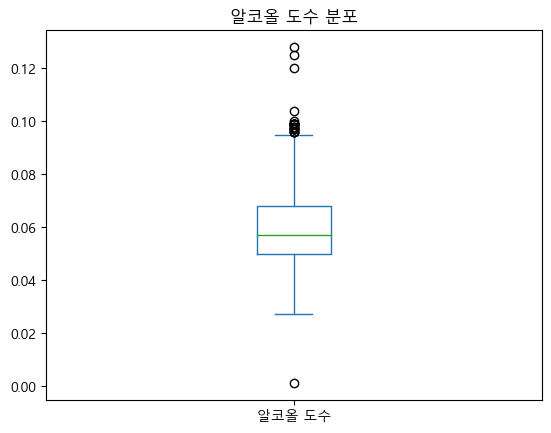

In [123]:
named_beers_df['알코올 도수'].plot(kind='box')
plt.title('알코올 도수 분포')
plt.show()

우리가 흔히 생각하는 맥주의 도수에 분포가 몰려있는데, 12도 이상의 높은 분포를 보이는 맥주들도 있다.

In [124]:
named_beers_df[named_beers_df['알코올 도수'] == np.max(named_beers_df['알코올 도수'])]

,알코올 도수,쓴 정도,id,이름,스타일,brewery_id,질량
2278,0.128,NaN,2565,Lee Hill Series Vol. 5 - Belgian Style Quadrup...,Quadrupel (Quad),51,19.2


알코올 도수가 최대값인 맥주는 Lee Hill Series Vol. 5 - Belgian Style Quadrup... 로 12.8%에 달한다.

In [125]:
named_beers_df[named_beers_df['알코올 도수'] == np.min(named_beers_df['알코올 도수'])]

,알코올 도수,쓴 정도,id,이름,스타일,brewery_id,질량
2266,0.001,NaN,606,Scotty K NA,Low Alcohol Beer,522,16.0


알코올 도수가 최소값인 맥주는 Scotty K NA로 0.1%다. 음료수 아님?

In [126]:
print(f"결측치 개수: {named_beers_df['알코올 도수'].isna().sum()}")
print(f"결측치 비율: {round(named_beers_df['알코올 도수'].isna().sum() * 100 / named_beers_df['알코올 도수'].count(), 2)}%")

결측치 개수: 60
결측치 비율: 2.67%


#### 2-1-3. 컬럼별 분포 확인(쓴 정도)

In [127]:
named_beers_df['쓴 정도'].describe().to_frame()

,쓴 정도
count,1326.000000
mean,42.957768
std,25.972636
min,4.000000
25%,22.000000
50%,35.000000
75%,64.000000
max,138.000000


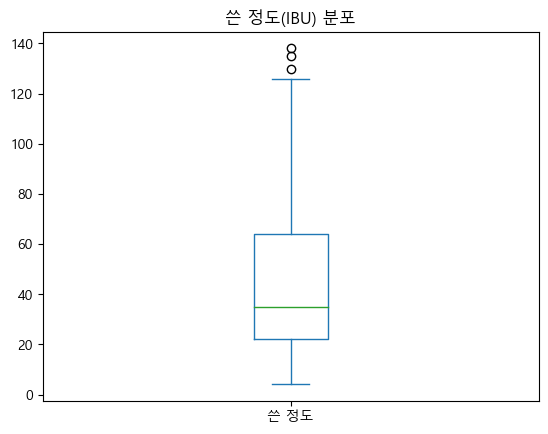

In [128]:
named_beers_df['쓴 정도'].plot(kind='box')
plt.title('쓴 정도(IBU) 분포')
plt.show()

쓴 정도는 21 ~ 64에 몰려있다. 찾아봤을 때에는 0부터 100까지의 스케일로 되어있다고 했는데 왜 138 같은 애가 있는지 잘 모르겠다.

In [129]:
named_beers_df[named_beers_df['쓴 정도'] == np.max(named_beers_df['쓴 정도'])]

,알코올 도수,쓴 정도,id,이름,스타일,brewery_id,질량
147,0.082,138.0,980,Bitter Bitch Imperial IPA,American Double / Imperial IPA,374,12.0


이름부터가 Bitter인 거 보니까 작정하고 쓰게 만들었나... 원래 맥주면 100 안에 들어와야 하는데 그것보다도 훨씬 써서 138인가?

In [130]:
named_beers_df[named_beers_df['쓴 정도'] == np.min(named_beers_df['쓴 정도'])]

,알코올 도수,쓴 정도,id,이름,스타일,brewery_id,질량
106,0.056,4.0,1350,Summer Solstice,Cream Ale,171,12.0
112,0.056,4.0,753,Summer Solstice Cerveza Crema (2009),Cream Ale,171,12.0
117,0.056,4.0,77,Summer Solstice (2011),Cream Ale,171,12.0


나는 쓴 맛을 싫어해서 이 친구들이 가장 좋을 것 같다. 셋 다 Cream Ale 스타일인 걸 보면 나중에 스타일별로 알코올 도수, 쓴 정도 보는 것도 재밌겠다.

In [131]:
print(f"결측치 개수: {named_beers_df['쓴 정도'].isna().sum()}")
print(f"결측치 비율: {round(named_beers_df['쓴 정도'].isna().sum() * 100 / named_beers_df['알코올 도수'].count(), 2)}%")

결측치 개수: 979
결측치 비율: 43.61%


결측치 겁나 많네...

#### 2-1-5. 컬럼별 분포 확인(스타일)

In [132]:
named_beers_df['스타일'].nunique()

99

In [133]:
beer_styles_df = named_beers_df['스타일'].value_counts().to_frame().rename(columns={'스타일': '개수'})
beer_styles_df

,개수
American IPA,409
American Pale Ale (APA),233
American Amber / Red Ale,131
American Blonde Ale,103
American Double / Imperial IPA,99
...,...
American Malt Liquor,1
Wheat Ale,1
Flanders Red Ale,1
Kristalweizen,1


In [134]:
print("개수가 10개 미만인 스타일:", end=' ')
print(f"{int(beer_styles_df[beer_styles_df['개수'] < 10].count())}종")

print("개수가 10개 이상 50개 미만인 스타일:", end=' ')
print(f"{int(beer_styles_df[(beer_styles_df['개수'] >= 10) & (beer_styles_df['개수'] < 50)].count())}종")

print("개수가 50개 이상인 스타일:", end=' ')
print(f"{int(beer_styles_df[beer_styles_df['개수'] >= 50].count())}종")

개수가 10개 미만인 스타일: 51종
개수가 10개 이상 50개 미만인 스타일: 38종
개수가 50개 이상인 스타일: 10종


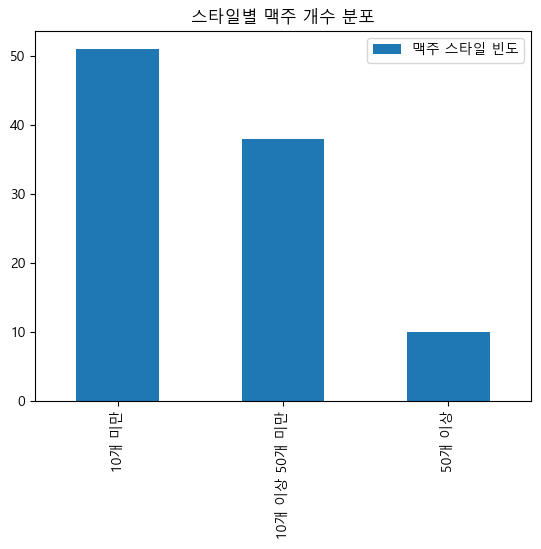

In [169]:
pd.DataFrame({
    '10개 미만': int(beer_styles_df[beer_styles_df['개수'] < 10].count()),
    '10개 이상 50개 미만': int(beer_styles_df[(beer_styles_df['개수'] >= 10) & (beer_styles_df['개수'] < 50)].count()),
    '50개 이상': int(beer_styles_df[beer_styles_df['개수'] >= 50].count())
}, index=['맥주 스타일 빈도']).T.plot(kind='bar')

plt.title('스타일별 맥주 개수 분포')
plt.show()

개수가 10개 미만인 스타일이 51종이나 있다.

In [170]:
beer_styles_df[beer_styles_df['개수'] < 10]['개수'].value_counts().to_frame().reset_index().rename(columns={
    '개수': '맥주 스타일 빈도',
    'index': '개수'
}).sort_values('개수').set_index('개수')

,맥주 스타일 빈도
개수,
1,10
2,7
3,9
4,4
5,5
6,8
7,4
9,4


보니까 개수가 1개뿐인 스타일도 10종이나 있다. 맥주 스타일이 이렇게 다양하게 있구나...

#### 2-1-6. 컬럼별 분포 확인(질량)

In [136]:
named_beers_df['질량'].describe()

count    2305.000000
mean       13.587375
std         2.363536
min         8.400000
25%        12.000000
50%        12.000000
75%        16.000000
max        32.000000
Name: 질량, dtype: float64

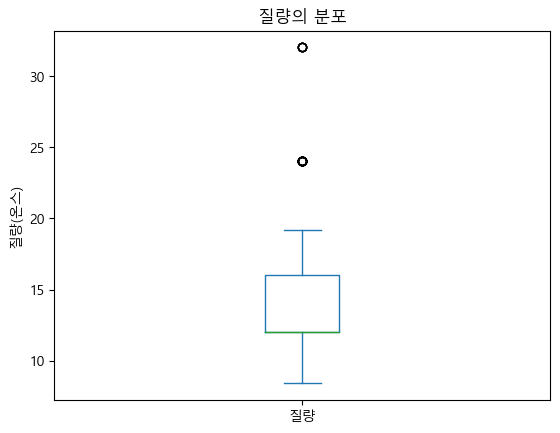

In [137]:
named_beers_df['질량'].plot(kind='box')
plt.title('질량의 분포')
plt.ylabel('질량(온스)')
plt.show()

12온스가 압도적으로 많은 분포를 띠는 모양이다. 12온스는 약 340g이다. 우리가 흔히 보는 355ml짜리 캔을 말하는 것 같다.

In [138]:
named_beers_df['질량'].value_counts()

12.0    1463
16.0     800
24.0      22
19.2      13
32.0       5
8.4        1
16.9       1
Name: 질량, dtype: int64

16온스는 454g이니까 500ml 캔인 것 같다. 역시 355ml와 500ml 용량이 압도적인 분포를 보인다.

In [139]:
named_beers_df[named_beers_df['질량'] == np.max(named_beers_df['질량'])]

,알코올 도수,쓴 정도,id,이름,스타일,brewery_id,질량
1374,0.050,NaN,2442,Cortez Gold,Belgian Pale Ale,98,32.0
1375,0.068,66.0,2441,Mission IPA,American IPA,98,32.0
1376,0.048,44.0,1460,El Conquistador Extra Pale Ale,American Pale Ale (APA),98,32.0
1377,0.092,75.0,1459,Shipwrecked Double IPA,American Double / Imperial IPA,98,32.0
1554,NaN,NaN,1796,The CROWLER™,NaN,166,32.0


가장 큰 맥주는 32온스(=907g)이다. 분명 캔맥주 데이터랬는데 1L짜리 캔이 있다고?!

In [140]:
named_beers_df[named_beers_df['질량'] == np.min(named_beers_df['질량'])]

,알코올 도수,쓴 정도,id,이름,스타일,brewery_id,질량
21,0.099,92.0,1036,Lower De Boom,American Barleywine,368,8.4


가장 작은 맥주는 8.4온스(=238g)이다. 

### 2-2. breweries.csv

#### 2-2-1. 데이터 불러오기

In [5]:
breweries_df = pd.read_csv('breweries.csv')
breweries_df

,Unnamed: 0,name,city,state
0,0,NorthGate Brewing,Minneapolis,MN
1,1,Against the Grain Brewery,Louisville,KY
2,2,Jack's Abby Craft Lagers,Framingham,MA
3,3,Mike Hess Brewing Company,San Diego,CA
4,4,Fort Point Beer Company,San Francisco,CA
...,...,...,...,...
553,553,Covington Brewhouse,Covington,LA
554,554,Dave's Brewfarm,Wilson,WI
555,555,Ukiah Brewing Company,Ukiah,CA
556,556,Butternuts Beer and Ale,Garrattsville,NY


In [142]:
breweries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558 entries, 0 to 557
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  558 non-null    int64 
 1   name        558 non-null    object
 2   city        558 non-null    object
 3   state       558 non-null    object
dtypes: int64(1), object(3)
memory usage: 17.6+ KB


In [143]:
breweries_df.isna().sum()

Unnamed: 0    0
name          0
city          0
state         0
dtype: int64

```breweries_df```를 보면서 생각한 것
- 있어야 할 ```brewery_id``` 컬럼이 없다. 아마 맨 앞에 index로 들어가야 하는 컬럼(```Unnamed: 0```)이 그 역할인 것 같다.
- 솔직히 얘는 컬럼명 알아보기 쉬워서 한글화 딱히 필요없을 듯
- 근데 추후 merge할 때를 생각하면 컬럼명에 양조장을 붙여야 더 구체적으로 설명이 될 것 같다
- 정수형 데이터가 하나도 없고 전부 텍스트로 구성되어 있다
- 결측치 하나도 없어서 아주 마음에 든다

In [6]:
named_breweries_df = breweries_df.rename(columns={
    'Unnamed: 0': 'brewery_id', 'name': '양조장 이름', 'city': '양조장 소재 도시', 'state': '양조장 소재 주'
})

named_breweries_df

,brewery_id,양조장 이름,양조장 소재 도시,양조장 소재 주
0,0,NorthGate Brewing,Minneapolis,MN
1,1,Against the Grain Brewery,Louisville,KY
2,2,Jack's Abby Craft Lagers,Framingham,MA
3,3,Mike Hess Brewing Company,San Diego,CA
4,4,Fort Point Beer Company,San Francisco,CA
...,...,...,...,...
553,553,Covington Brewhouse,Covington,LA
554,554,Dave's Brewfarm,Wilson,WI
555,555,Ukiah Brewing Company,Ukiah,CA
556,556,Butternuts Beer and Ale,Garrattsville,NY


#### 2-2-2. 컬럼별 분포 확인(양조장 이름)

In [145]:
named_breweries_df['양조장 이름'].nunique()

551

In [7]:
named_breweries_df[named_breweries_df['양조장 이름'].duplicated()].sort_values('양조장 이름')

,brewery_id,양조장 이름,양조장 소재 도시,양조장 소재 주
95,95,Blackrocks Brewery,Marquette,MA
414,414,Blue Mountain Brewery,Arrington,VA
456,456,Lucette Brewing Company,Menominie,WI
503,503,Oskar Blues Brewery,Lyons,CO
275,275,Otter Creek Brewing,Middlebury,VT
371,371,Sly Fox Brewing Company,Pottstown,PA
138,138,Summit Brewing Company,St Paul,MN


7개의 중복된 양조장이 들어가 있다.

In [7]:
named_breweries_df.drop_duplicates('양조장 이름', inplace=True)
named_breweries_df

,brewery_id,양조장 이름,양조장 소재 도시,양조장 소재 주
0,0,NorthGate Brewing,Minneapolis,MN
1,1,Against the Grain Brewery,Louisville,KY
2,2,Jack's Abby Craft Lagers,Framingham,MA
3,3,Mike Hess Brewing Company,San Diego,CA
4,4,Fort Point Beer Company,San Francisco,CA
...,...,...,...,...
553,553,Covington Brewhouse,Covington,LA
554,554,Dave's Brewfarm,Wilson,WI
555,555,Ukiah Brewing Company,Ukiah,CA
556,556,Butternuts Beer and Ale,Garrattsville,NY


#### 2-2-3. 컬럼별 분포 확인(양조장 소재 도시)

In [172]:
cities_df = named_breweries_df['양조장 소재 도시'].value_counts().to_frame().rename(columns={'양조장 소재 도시': '개수'})
cities_df

,개수
Portland,17
Chicago,9
Seattle,9
Boulder,9
San Diego,8
...,...
Henderson,1
Buellton,1
Dripping Springs,1
Gloucester,1


In [177]:
cities_df['개수'].value_counts().to_frame().reset_index().sort_values('index').rename(columns={
    'index': '개수', '개수': '도시 수'
}).set_index('개수')

,도시 수
개수,
1,299
2,51
3,17
4,5
5,1
6,1
8,3
9,3
17,1


양조장이 1개 있는 도시가 299개나 있다. 양조장이 굉장히 다양하게 분포되어 있음을 파악할 수 있다.

#### 2-2-4. 컬럼별 분포 확인(양조장 소재 주)

In [194]:
states_df = named_breweries_df['양조장 소재 주'].value_counts().to_frame().reset_index().rename(columns={
    '양조장 소재 주': '개수', 'index': '주'
})
states_df

,주,개수
0,CO,46
1,CA,39
2,MI,32
3,OR,29
4,TX,28
5,PA,24
6,WA,23
7,MA,22
8,IN,22
9,NC,19


아 예... 그렇군요

### 2-3. 데이터 병합

#### 2-3-1. 데이터 합치기

In [8]:
merged_df = pd.merge(
    left=named_beers_df,
    right=named_breweries_df,
    how='left',
    on='brewery_id'
)

merged_df

,알코올 도수,쓴 정도,id,이름,스타일,brewery_id,질량,양조장 이름,양조장 소재 도시,양조장 소재 주
0,0.050,NaN,1436,Pub Beer,American Pale Lager,408,12.0,10 Barrel Brewing Company,Bend,OR
1,0.066,NaN,2265,Devil's Cup,American Pale Ale (APA),177,12.0,18th Street Brewery,Gary,IN
2,0.071,NaN,2264,Rise of the Phoenix,American IPA,177,12.0,18th Street Brewery,Gary,IN
3,0.090,NaN,2263,Sinister,American Double / Imperial IPA,177,12.0,18th Street Brewery,Gary,IN
4,0.075,NaN,2262,Sex and Candy,American IPA,177,12.0,18th Street Brewery,Gary,IN
...,...,...,...,...,...,...,...,...,...,...
2300,0.067,45.0,928,Belgorado,Belgian IPA,424,12.0,Wynkoop Brewing Company,Denver,CO
2301,0.052,NaN,807,Rail Yard Ale,American Amber / Red Ale,424,12.0,Wynkoop Brewing Company,Denver,CO
2302,0.055,NaN,620,B3K Black Lager,Schwarzbier,424,12.0,Wynkoop Brewing Company,Denver,CO
2303,0.055,40.0,145,Silverback Pale Ale,American Pale Ale (APA),424,12.0,Wynkoop Brewing Company,Denver,CO


#### 2-3-2. 결측치 처리

In [17]:
merged_df.isna().sum()

알코올 도수         60
쓴 정도          979
id              0
이름              0
스타일             5
brewery_id      0
질량              0
양조장 이름         32
양조장 소재 도시      32
양조장 소재 주       32
dtype: int64

다른 컬럼들은 제거해 주면 될 것 같은데 쓴 정도 컬럼이 너무 많다.

In [19]:
merged_df[merged_df['쓴 정도'].isna()]['스타일'].value_counts()

American IPA                121
American Pale Ale (APA)      91
American Amber / Red Ale     55
American Blonde Ale          46
Cider                        36
                           ... 
English Strong Ale            1
Kristalweizen                 1
Euro Pale Lager               1
Munich Dunkel Lager           1
Chile Beer                    1
Name: 스타일, Length: 88, dtype: int64

같은 스타일이면 비슷한 쓴 정도를 나타낸다고 가정하고, 결측치를 **해당 스타일의 평균**으로 대체한다.

In [9]:
for idx, row in merged_df.iterrows():
    if pd.isna(row['쓴 정도']):
        merged_df.at[idx, '쓴 정도'] = merged_df[merged_df['스타일'] == row['스타일']]['쓴 정도'].mean()

In [54]:
merged_df.isna().sum()

알코올 도수        60
쓴 정도          54
id             0
이름             0
스타일            5
brewery_id     0
질량             0
양조장 이름        32
양조장 소재 도시     32
양조장 소재 주      32
dtype: int64

In [64]:
print(f"결측치 개수: {merged_df['쓴 정도'].isna().sum()}")
print(f"결측치 비율: {round(merged_df['쓴 정도'].isna().sum() * 100 / merged_df['쓴 정도'].count(), 2)}%")

결측치 개수: 54
결측치 비율: 2.4%


여전히 54개의 결측치가 들어가 있는데, 아마 해당 스타일에 해당하는 쓴 정도 값이 전부 결측치인 경우일 것이다. 이런 경우에는 그냥 drop해주는 것이 편하겠다.

In [10]:
merged_df.dropna(inplace=True)

In [70]:
merged_df.isna().sum()

알코올 도수        0
쓴 정도          0
id            0
이름            0
스타일           0
brewery_id    0
질량            0
양조장 이름        0
양조장 소재 도시     0
양조장 소재 주      0
dtype: int64

## 3. 데이터 분석

이슬(26)씨는 원래 소주 회사에 재직하다가 최근 미국 수제 맥주 회사의 제품 기획팀으로 이직하였다. 이슬씨의 회사는 갓 법인을 창립하여 이제 수제 맥주 시장에 발을 들이려는 따끈따끈한 신생 회사다. 이슬씨가 속한 제품 기획팀의 목표는 소비자들에게 인정받고 시장에서 성공할 만한 신규 제품을 개발하는 것이다. 제품 기획에 앞서 수제 맥주 시장에 대한 리서치를 진행하던 이슬씨는 수제 맥주를 이루는 두 가지 주요 핵심 사항에 대해 알게 되었다.

- 알코올 도수
- 쓴 정도

이슬씨는 이 두 요인을 기준으로 시장에서 제품 포지셔닝을 잡는 게 좋겠다고 생각했다. 그래서 우선적으로 시중에 있는 제품들의 알코올 도수와 쓴 정도를 분석하고, 소비자 선호도가 높은 제품의 특성을 발굴하여, 신규 제품의 레퍼런스로 삼기로 결정했다.

본 분석에서는 이슬씨의 입장에서 **신규 제품의 시장 내 포지셔닝**을 기획하는 과정을 수행한다.

### 3-1. 알코올 도수와 쓴 정도 사이의 관계 분석 (선형회귀)

먼저, 시중에 존재하는 수제 맥주 제품들을 대상으로, 알코올 도수와 쓴 정도 사이에 어떤 선형 관계가 존재하는지를 확인해 보고자 한다.

In [31]:
X = merged_df['알코올 도수'].values
y = merged_df['쓴 정도'].values

lr_result = stats.linregress(X, y)
lr_result

LinregressResult(slope=1031.2859321897258, intercept=-20.729009038366392, rvalue=0.5852119836413339, pvalue=9.905659111408955e-199, stderr=30.760751150512718, intercept_stderr=1.886702591052626)

In [32]:
beta_0 = lr_result.intercept
beta_1 = lr_result.slope
p_value = lr_result.pvalue

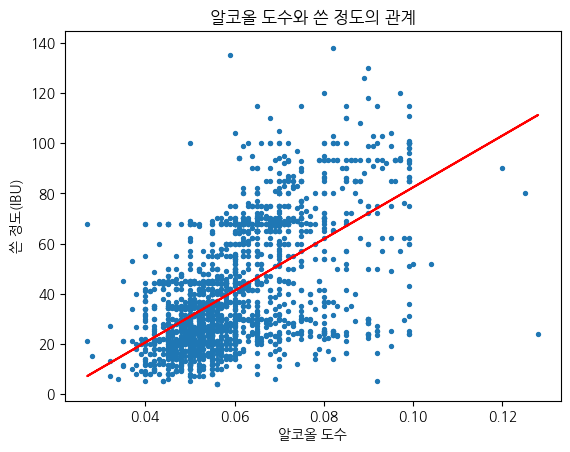

In [33]:
plt.scatter(X, y, s=8)
plt.plot(X, beta_1*X + beta_0, color='red')
plt.xlabel('알코올 도수')
plt.ylabel('쓴 정도(IBU)')
plt.title('알코올 도수와 쓴 정도의 관계')
plt.show()

산점도를 통해 확인해 본 결과 알코올 도수와 쓴 정도 사이에는 **양의 상관관계**가 존재함을 파악할 수 있었다. 이어서 이 회귀선이 유의미한지를 분석해 본다.

In [98]:
alpha = 0.05
if p_value < alpha:
    print('회귀계수가 통계적으로 유의미하다.')
else:
    print('회귀계수가 통계적으로 유의미하지 않다.')

회귀계수가 통계적으로 유의미하다.


알코올 도수와 쓴 정도 사이에 유의미한 상관관계가 있는 것으로 분석되었다. 이상의 결과를 요약하면, 전반적으로 센 맥주(알코올 도수가 높은 맥주)일수록 쓴 맛도 강하고, 약한 맥주(알코올 도수가 낮은 맥주)일수록 쓴 맛도 약한 편으로 이해할 수 있다. 그렇다면 우리가 취할 수 있는 제품 포지셔닝 전략은 다음과 같을 것이다.
- 매니아틱한 수제 맥주 (알코올 도수가 강하고, 쓴 맛이 강한 제품)
- 입문용 수제 맥주 (알코올 도수가 약하고, 쓴 맛이 약한 제품)

### 3-2. 소비자 선호도가 높은 제품군 분석 (클러스터링)

우리가 표본으로 사용하는 데이터에는 제품의 판매량이나 소비자의 선호도 같은 직접적인 지표가 없기 때문에, 간접적인 방법을 통해 결과를 도출해야 한다. 따라서 본 분석에서는 **시장에 많이 출시된 유형**의 제품일수록 **소비자의 선호도가 높은** 것으로 가정한다.

소비자의 선호도가 높은 제품의 특성을 알아보기 위해, 수제 맥주를 구성하는 주요 요인(알코올 도수, 쓴 정도)에 따른 **클러스터링**을 수행한다.

C:\Users\louis\anaconda3\envs\ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\louis\anaconda3\envs\ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\louis\anaconda3\envs\ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\louis\anaconda3\envs\ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\louis\anaconda3

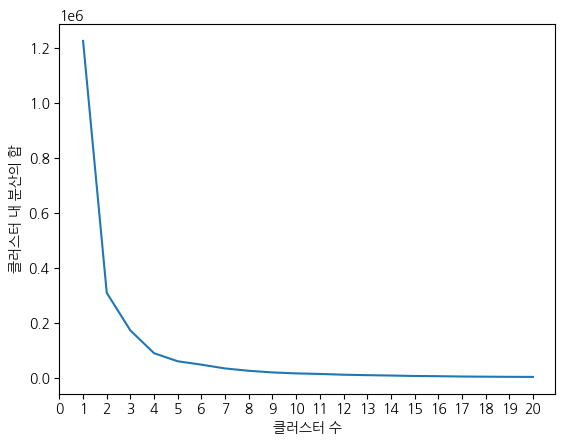

In [34]:
X = merged_df[['알코올 도수', '쓴 정도']]

# 적절한 K 값을 결정하기 위한 엘보우 메소드
wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# 엘보우 그래프를 그려서 적절한 K 값을 선택
plt.plot(range(1, 21), wcss)
plt.xticks([i for i in range(21)])
plt.xlabel('클러스터 수')
plt.ylabel('클러스터 내 분산의 합')
plt.show()

엘보우 메소드에 따라 군집의 개수 **k = 4**로 결정한다.

In [35]:
kmeans = KMeans(n_clusters=4, random_state=0)
merged_df['클러스터'] = kmeans.fit_predict(X)
merged_df

C:\Users\louis\anaconda3\envs\ml\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,알코올 도수,쓴 정도,id,이름,스타일,brewery_id,질량,양조장 이름,양조장 소재 도시,양조장 소재 주,클러스터
0,0.050,26.600000,1436,Pub Beer,American Pale Lager,408,12.0,10 Barrel Brewing Company,Bend,OR,2
1,0.066,44.394366,2265,Devil's Cup,American Pale Ale (APA),177,12.0,18th Street Brewery,Gary,IN,0
2,0.071,67.694444,2264,Rise of the Phoenix,American IPA,177,12.0,18th Street Brewery,Gary,IN,3
3,0.090,93.323944,2263,Sinister,American Double / Imperial IPA,177,12.0,18th Street Brewery,Gary,IN,1
4,0.075,67.694444,2262,Sex and Candy,American IPA,177,12.0,18th Street Brewery,Gary,IN,3
...,...,...,...,...,...,...,...,...,...,...,...
2300,0.067,45.000000,928,Belgorado,Belgian IPA,424,12.0,Wynkoop Brewing Company,Denver,CO,0
2301,0.052,36.539474,807,Rail Yard Ale,American Amber / Red Ale,424,12.0,Wynkoop Brewing Company,Denver,CO,0
2302,0.055,31.000000,620,B3K Black Lager,Schwarzbier,424,12.0,Wynkoop Brewing Company,Denver,CO,0
2303,0.055,40.000000,145,Silverback Pale Ale,American Pale Ale (APA),424,12.0,Wynkoop Brewing Company,Denver,CO,0


4개의 클러스터 각각에 대한 특성치들을 알아본다.

In [36]:
cluster_stats = merged_df.groupby('클러스터').agg({
    '이름': 'count',
    '알코올 도수': 'mean',
    '쓴 정도': 'mean'
}).rename(columns={'이름': '개수'})

cluster_stats

,개수,알코올 도수,쓴 정도
클러스터,,,
0,644,0.056857,38.270879
1,176,0.081205,92.954105
2,886,0.054133,20.123265
3,454,0.066868,65.332110


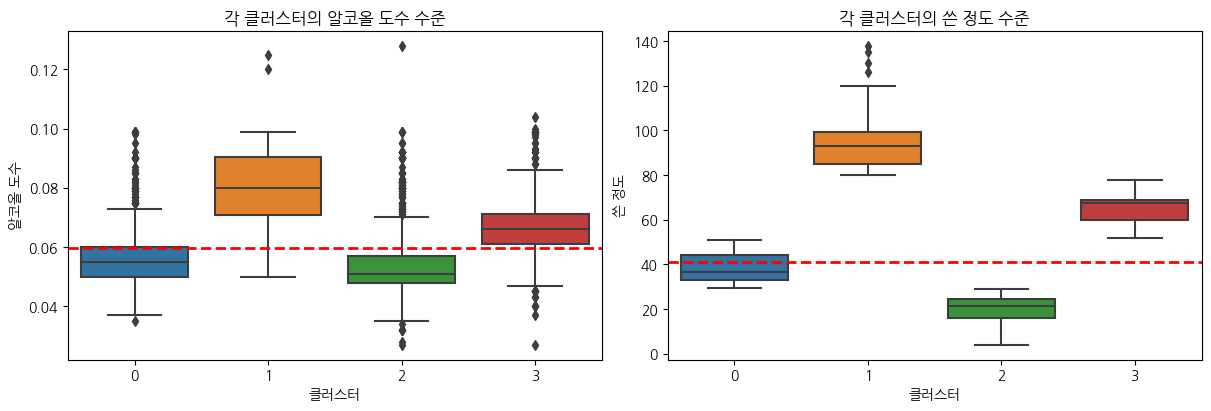

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), constrained_layout=True)

sns.boxplot(x='클러스터', y='알코올 도수', data=merged_df, ax=axes[0])
axes[0].axhline(merged_df['알코올 도수'].mean(), linestyle='--', color='red', linewidth=2)
axes[0].set_title('각 클러스터의 알코올 도수 수준')

sns.boxplot(x='클러스터', y='쓴 정도', data=merged_df, ax=axes[1])
axes[1].axhline(merged_df['쓴 정도'].mean(), linestyle='--', color='red', linewidth=2)
axes[1].set_title('각 클러스터의 쓴 정도 수준')

plt.show()

대략적으로 살펴봤을 때, 매니아틱한 제품군이 1, 평균 제품군이 0과 3, 입문자용 제품군이 2인 것 같다.

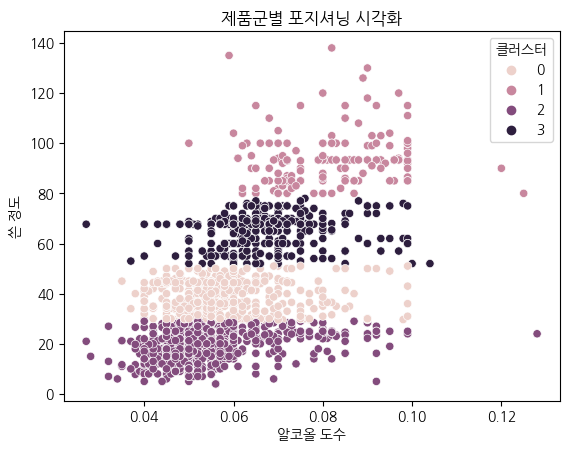

In [38]:
sns.scatterplot(merged_df, x='알코올 도수', y='쓴 정도', hue='클러스터')
plt.title('제품군별 포지셔닝 시각화')
plt.show()

산점도로 그려보니 보다 뚜렷하게 구분된다. 다만 클러스터별 차이가 통계적으로 유의미한 것인지를 확인해 볼 필요는 있다. 지금부터는 알코올 도수와 쓴 정도가 **평균 대비 25% 이상** 뚜렷하게 구분되는 특징인지를 확인해 보고자 한다. 이 과정에는 Z-Score를 사용한다.

In [39]:
# Z-score를 계산
z_scores = stats.zscore(cluster_stats)

z_scores

,개수,알코올 도수,쓴 정도
클러스터,,,
0,0.399982,-0.745417,-0.576653
1,-1.399938,1.549440,1.406668
2,1.330710,-1.002163,-1.234853
3,-0.330755,0.198139,0.404838


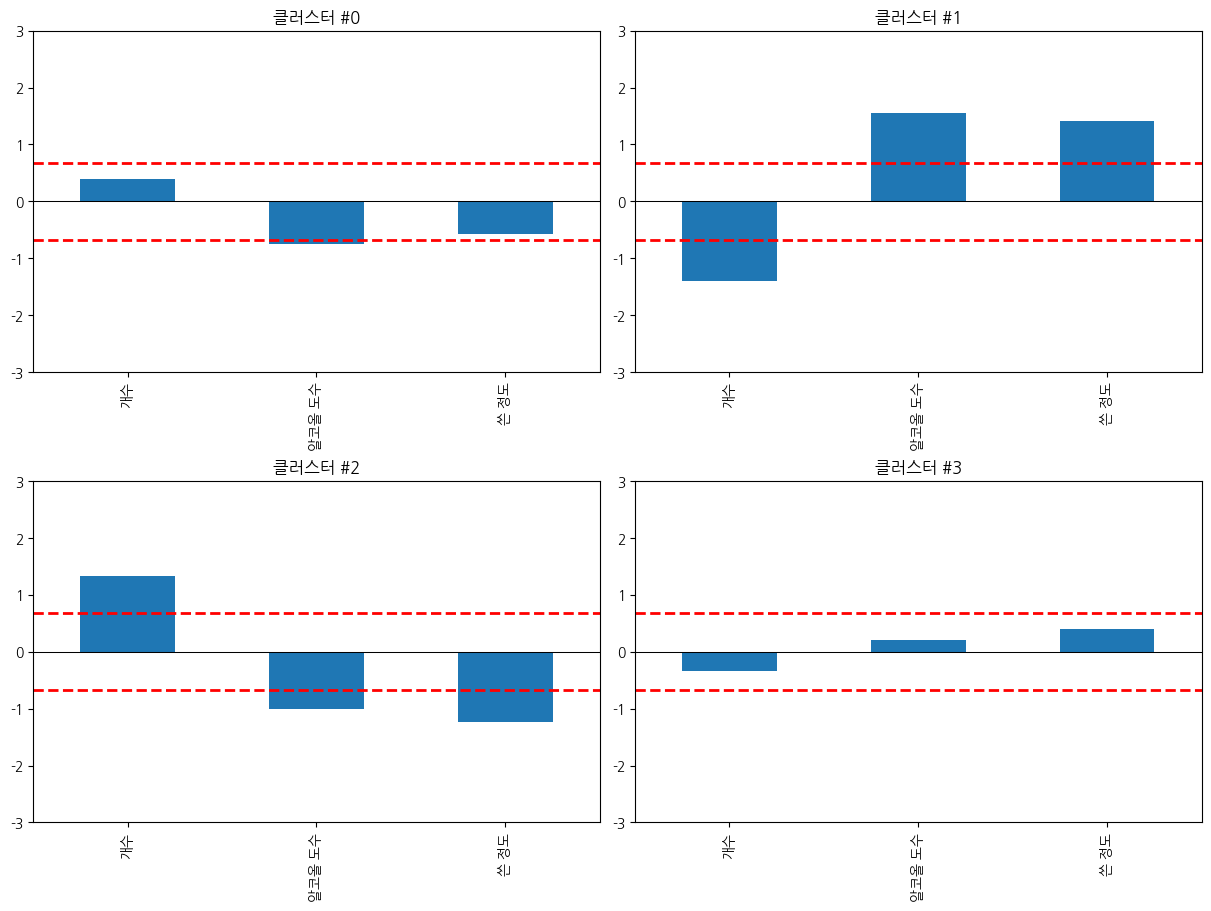

In [40]:
# 25% 이상 크거나 작은 값을 확인
threshold = 0.674

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 9), constrained_layout=True)

for i in range(2):
    for j in range(2):
        axes[i][j].set_title(f"클러스터 #{2 * i + j}")
        z_scores.loc[2 * i + j].plot(kind='bar', ax=axes[i][j])
        axes[i][j].set_yticks([i for i in range(-3, 4)])
        axes[i][j].axhline(threshold, color='red', linestyle='--', linewidth=2)
        axes[i][j].axhline(0, color='black', linewidth=0.75)
        axes[i][j].axhline(-threshold, color='red', linestyle='--', linewidth=2)

개수가 평균보다 유의미하게 많은 클러스터는 2번이다. 본 분석에서 가정한 바에 따라 2번 제품군이 가장 소비자 선호도가 높다. 이때 2번 제품군에 속하는 제품들은 알코올 도수와 쓴 정도가 모두 전체 제품 평균보다 25% 이상 두드러지게 낮은 수치를 가진다. 즉 **진입장벽이 낮을수록 대중적이다**라는 진리에 가까운 결과를 얻을 수 있다.

이슬씨는 이 분석 결과를 접목하여 신규 제품 'HONEY DEW'를 다음과 같이 고안했다.
- 산뜻하고 캐주얼한 노란색 캔 디자인
- 알코올 도수가 5.4%로 낮고, 쓴 정도가 20으로 약한 제품
- 가벼운 마음으로 먹을 수 있다는 취지의 마케팅 (치맥 같은 거)

## 4. 후기

본 분석을 통해 미국 수제 맥주 시장을 구성하는 다양한 제품들을 확인해 보았다. 미국 수제 맥주 시장에서는 알코올 도수가 낮고, 쓴 정도가 낮은 제품군의 점유율이 두드러지게 높은 점을 파악할 수 있었다.

이번 분석에서 쓴 데이터셋은 어떤 개인 유저에 의해 직접적으로 수집된 데이터이기 때문에 예쁘게 가공되어 있지는 않았다. 중복된 데이터가 여러 개 포함되어 있는 경우가 있어서 그것에 대한 별도의 처리가 필요했고, 또한 IBU 같은 **핵심 컬럼의 결측치**가 다소 많아서 마음 편하게 drop해버리지 못하는 문제도 있었다. 특히 결측치 문제는 어떻게 처리할지 많은 고민이 필요했는데, 최종적으로 제품 스타일 단위로 평균을 취해서 넣어주었다. 결측치 처리 문제는 현업의 데분에서 정말 많이 고민해야 하는 요인이라고 들었는데 그런 과정을 일부분 경험해 볼 수 있었고 추후에도 이런 데이터들을 활용하면 경험치를 더욱 쌓아나갈 수 있겠다는 생각을 했다.

이번 분석에서는 상황을 만들어서 그 상황에 몰입하는 방식으로 진행해 보았다. 제품 기획팀의 입장에서 어떤 식으로 시장을 분석해 나갈지 생각해 볼 수 있었던 경험이었다. 또한 얻어내야 하는 인사이트를 어떤 방식으로 접근할지도 고민해 볼 수 있었다. 최종적으로 선형회귀분석과 클러스터링을 적용하여 분석을 진행했다.

아쉬웠던 점은 역시 실제 시장에서의 판매량 또는 고객 데이터를 구할 수 없었다는 점이다. 실제 판매량을 도입하거나, 유저 데이터를 활용할 수 이 있었더라면 더욱 정교한 분석을 진행해 볼 수 있었을 것이다.